# Introduction to Microsoft R Operationalization

## Summary

Build a simple a model using R, then operationalize the model as a web service on Microsoft R Server (MRS). MRS can be run either on the cloud or onpremises. 

## Pre-requisites

You should have enabled Microsoft R Server Operationalization (O16N) to deploy models as web service. If you have not done this yet, you can do so by running the "Microsoft-R-Admin-Util" and then choose option 1 (Configure R Server for Operationalization). A shortcut is available on the desktop or you can search from the start menu. 

## Description

The purpose of this notebook is to demonstrate how to use Jupyter notebooks on the Microsoft R to develop a model in R and publish a web service based on the model.

### Using Jupyter notebooks

For data scientists new to Jupyter and accustomed to doing all analytical work using R on local computers, the Data Science Virtual Machine makes it possible to write R notebooks on the cloud. So anyone with internet access can work with R from a web browser. 

If you use R, notebooks make it possible to develop your models in R and then operationalize them easily. 



## Data

In this example, you use the Boston housing data from the R package `MASS`.  The `Boston` dataset contains 506 rows and 14 columns. Available information includes median home price, average number of rooms per dwelling, crime rate by town, etc. More information about this dataset can be found by typing `?Boston` or `help(Boston)` in an R terminal, or at this [UCI page][uci link].

To run a cell, select it and press CTRL+ENTER or SHIFT+ENTER.

[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

In [2]:
# load the library to use the Boston dataset
library(MASS)
?Boston

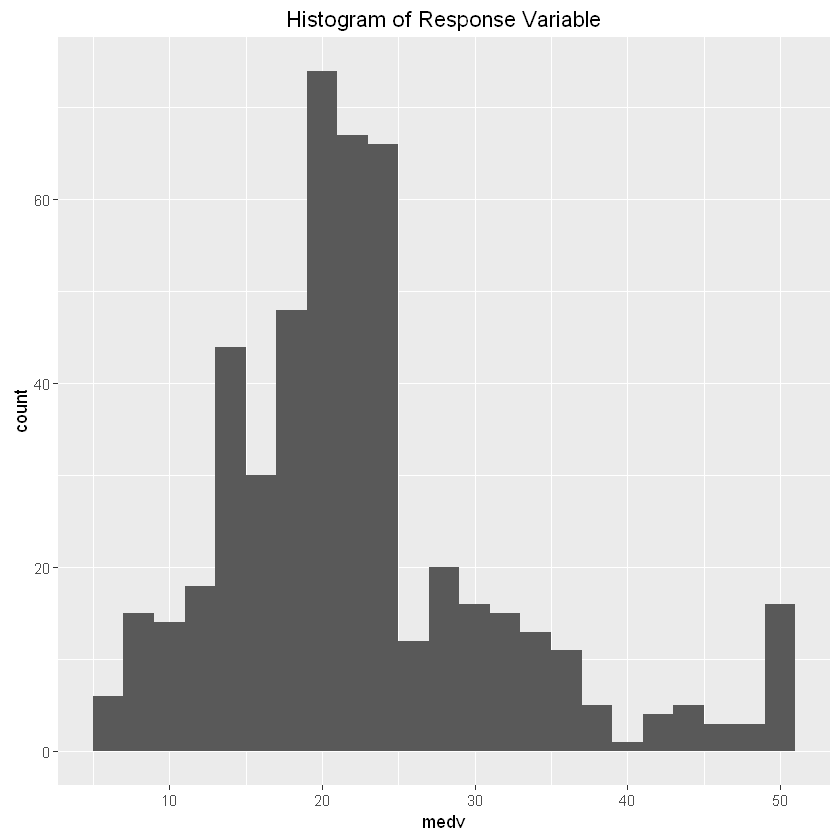

In [3]:
# library for plotting
library(ggplot2) 
# plot distribution of the response variable
ggplot(Boston, aes(x=medv)) + 
  geom_histogram(binwidth=2) +
  ggtitle("Histogram of Response Variable")

## A linear regression model

For illustration purposes, use `medv`, median home price, as the response variable and all other variables as predictors.

[uci link]: https://archive.ics.uci.edu/ml/datasets/Housing

We use the basic "lm" model in R in this sample. You can use the Microsoft R's ScaleR (aka RevoScaleR) library models to handle large scale datasets and use same process to operationalize it. Please refer to other notebook samples to work with Microsoft R's ScaleR library.

In [4]:
# fit a model using all variables except medv as predictors
lm1 <- lm(medv ~ ., data = Boston)

# check model performance
summary(lm1)


Call:
lm(formula = medv ~ ., data = Boston)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.595  -2.730  -0.518   1.777  26.199 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.646e+01  5.103e+00   7.144 3.28e-12 ***
crim        -1.080e-01  3.286e-02  -3.287 0.001087 ** 
zn           4.642e-02  1.373e-02   3.382 0.000778 ***
indus        2.056e-02  6.150e-02   0.334 0.738288    
chas         2.687e+00  8.616e-01   3.118 0.001925 ** 
nox         -1.777e+01  3.820e+00  -4.651 4.25e-06 ***
rm           3.810e+00  4.179e-01   9.116  < 2e-16 ***
age          6.922e-04  1.321e-02   0.052 0.958229    
dis         -1.476e+00  1.995e-01  -7.398 6.01e-13 ***
rad          3.060e-01  6.635e-02   4.613 5.07e-06 ***
tax         -1.233e-02  3.760e-03  -3.280 0.001112 ** 
ptratio     -9.527e-01  1.308e-01  -7.283 1.31e-12 ***
black        9.312e-03  2.686e-03   3.467 0.000573 ***
lstat       -5.248e-01  5.072e-02 -10.347  < 2e-16 ***
---
Signif. codes:  0

Now compute some error measures:

In [5]:
pred <- predict(lm1)
error <- pred - Boston$medv
mae <- mean(abs(error))
rmse <- sqrt(mean((error)^2))
rae <- mean(abs(error)) / mean(abs(Boston$medv - mean(Boston$medv)))
rse <- mean((error)^2) / mean((Boston$medv - mean(Boston$medv))^2)

cat("Mean Absolute Error:", round(mae, 6), "\n")
cat("Root Mean Squared Error:", round(rmse, 6), "\n")
cat("Relative Absolute Error:", round(rae, 6), "\n")
cat("Relative Squared Error:", round(rse, 6), "\n")

Mean Absolute Error: 3.270863 
Root Mean Squared Error: 4.679191 
Relative Absolute Error: 0.492066 
Relative Squared Error: 0.259357 


## Web service

### Deploy a web service



In [6]:
library(mrsdeploy)

In [7]:
help(mrsdeploy)

In [8]:
colnames(Boston)

[1] "crim"    "zn"      "indus"   "chas"    "nox"     "rm"      "age"    
 [8] "dis"     "rad"     "tax"     "ptratio" "black"   "lstat"   "medv"

### Publishing a web service

You use the function `publishService()` to deploy your model.


In [9]:
# define predict function
homepricepredict <- function(crim, zn, indus, chas, nox, rm, age, dis ,rad,tax,ptratio,black,lstat){
  inputData <- data.frame(crim=crim, zn=zn, indus=indus, chas=chas, nox=nox, rm=rm, age=age, dis=dis ,rad=rad,tax=tax,ptratio=ptratio,black=black,lstat=lstat)
  predict(lm1, inputData)
}

# a sample with predictor information
newdata <- Boston[5, ]

# test the prediction function
data.frame(
    actual = newdata$medv, 
    prediction = homepricepredict(newdata$crim, newdata$zn, newdata$indus, newdata$chas, newdata$nox, newdata$rm, newdata$age, newdata$dis 
                           ,newdata$rad,newdata$tax,newdata$ptratio,newdata$black,newdata$lstat))

actual,prediction
36.2,27.94352


In [10]:
# Remote Login, a prompt will show up to input user and pwd information
endpoint <- "http://localhost:12800"
# In jupyter you need to pass username and password as argument. 
# From an R IDE like RStudio or RTVS you can exclude username and password arg to be prompted with a login box
# See this same example slightly modified to run in R IDE in c:\dsvm\samples\mrsdeploy
remoteLogin(endpoint, session = FALSE, diff = FALSE, username="ENTER MRS Operationalization USERNAME", password="MRS Operationalization  PASSWORD")

In [12]:
service_name <- paste0("BostonhomepricePredictService", round(as.numeric(Sys.time()), 0))
api <- publishService(
  service_name,
  code = homepricepredict,
  model = lm1,
  inputs = list(crim = 'numeric', zn= 'numeric', indus= 'numeric', chas= 'numeric', nox= 'numeric', rm= 'numeric', age= 'numeric', dis= 'numeric' 
                ,rad= 'numeric',tax= 'numeric',ptratio= 'numeric',black= 'numeric',lstat= 'numeric'),
  outputs = list(medv = 'numeric'),
  v = 'v1.0.0'
)

### Consume a web service

After setting up a web service, you can use R to consume the model, either in the same session, or by saving some data about the web service, in any other (future) R session.

#### In-session consumption

If you are consuming the web service in the same session that the web service was set up, you can refer to the endpoint (api variable above) directly.



In [ ]:
api$capabilities()
#Consume the service
medvpred <- api$homepricepredict(0.14455, 12.5,  7.87,    0, 0.524, 6.172, 96.1 ,5.9505,   5, 311,    15.2, 396.9, 19.15)

medvpred$output("medv")

#List all services
services <- listServices()
services

#Generate swagger json file
cat(api$swagger(), file = "homevaluePredict.json")

#Logout
remoteLogout()


## Conclusion

In this example, you learned how to fit a model, deploy the model on Microsoft R Server and consume the service.

The `mrsdeploy` R package helps you easily deploy R (both open source and Microsoft R) within the R Server and allow consumption from applications using any language on the client. 